In [49]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformation
import data_filter as dafi
import estimate_height as esth

from scipy import signal

WAVELENTH_S1 = 0.1905 # meter


In [50]:
# 20220526 #2
import math
x = 4155252.3307
y = 674064.7850
z = 4775969.2638
lat,lon,height = transformation.xyz2latlon(x,y,z)
print(lat/math.pi*180)
print(lon/math.pi*180)
print(height)

48.797647635874426
9.214252131825374
270.97025138139725


In [51]:
main_path = 'E:/OneDrive/Studium/MA/data/phnx/'
main_path = 'E:/OneDrive/Studium/MA/data/phnx/'
main_path = os.path.abspath('../data/sc02/')
main_path = os.path.abspath('../data/phnx/')
#main_path = os.path.abspath('../data/20220526/2/')

data_dict = dafi.generate_dataframe(main_path)
satellite_list = data_dict.keys()

azimut_mask = [0,360]
elevation_mask = [0,25]
for satellite_code in satellite_list:
    data_dict[satellite_code] = dafi.azimut_filter(data_dict[satellite_code],azimut_mask)
    data_dict[satellite_code] = dafi.elevation_filter(data_dict[satellite_code],elevation_mask)

In [52]:
print(satellite_list)

dict_keys(['G01', 'G03', 'G04', 'G06', 'G09', 'G17', 'G19', 'G31', 'G11', 'G02', 'R04', 'R05', 'R06', 'R14', 'R15', 'R20', 'R21', 'R22', 'R07', 'E04', 'E05', 'E09', 'E11', 'E36', 'E34', 'E01', 'G07', 'E31', 'G20', 'G16', 'G30', 'R23', 'R09'])


In [53]:
satellite_code = 'G01'
dataframe = data_dict[satellite_code]
print(dataframe)

                          time   azimut  elevation   snr1   snr2
0    2022-05-26 19:31:05+00:00  150.067     24.358  43.80  43.40
1    2022-05-26 19:31:06+00:00  150.070     24.350  43.75  43.60
2    2022-05-26 19:31:07+00:00  150.072     24.343  44.10  44.10
3    2022-05-26 19:31:08+00:00  150.075     24.336  43.95  43.85
4    2022-05-26 19:31:09+00:00  150.077     24.328  43.95  43.80
...                        ...      ...        ...    ...    ...
3495 2022-05-26 20:29:20+00:00  155.900      0.030    NaN    NaN
3496 2022-05-26 20:29:21+00:00  155.901      0.024    NaN    NaN
3497 2022-05-26 20:29:22+00:00  155.902      0.017    NaN    NaN
3498 2022-05-26 20:29:23+00:00  155.903      0.010    NaN    NaN
3499 2022-05-26 20:29:24+00:00  155.904      0.004    NaN    NaN

[3500 rows x 5 columns]


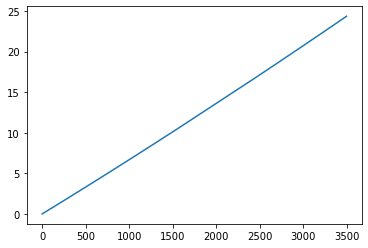

In [54]:
dataframe_sort = dataframe.sort_values(by='elevation')
plt.plot(np.array(dataframe_sort['elevation']))

[  nan   nan   nan ... 44.1  43.75 43.8 ]


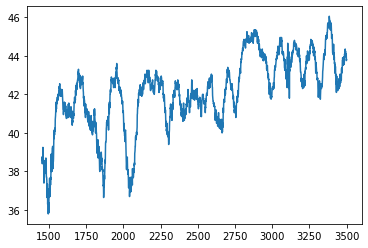

In [55]:
x = np.array(dataframe_sort['snr1'])
plt.plot(x)

print(x)

[  nan   nan   nan ... 44.1  43.75 43.8 ]


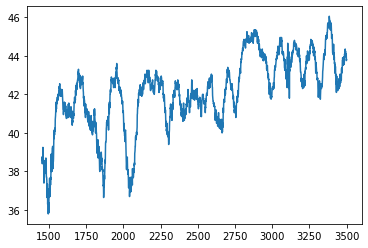

In [56]:
snr1_volt = np.array(np.exp(dataframe_sort['snr1']/20))
snr1_volt = np.array(dataframe_sort['snr1'])
plt.plot(snr1_volt)
print(snr1_volt)

In [57]:
elevation_sort = np.array(dataframe_sort['elevation'])
non_nan_index = ~np.isnan(snr1_volt)

elevation_filtered = elevation_sort[non_nan_index]
elevation_filtered = elevation_filtered.reshape(elevation_filtered.size,1)
snr1_volt_filtered = snr1_volt[non_nan_index]
snr1_volt_filtered = snr1_volt_filtered.reshape(snr1_volt_filtered.size,1)

design_matrix = np.concatenate((elevation_filtered**2,elevation_filtered,np.ones((elevation_filtered.size,1))),axis=1)
print(design_matrix)


[[ 95.883264   9.792      1.      ]
 [ 96.020401   9.799      1.      ]
 [ 96.157636   9.806      1.      ]
 ...
 [592.581649  24.343      1.      ]
 [592.9225    24.35       1.      ]
 [593.312164  24.358      1.      ]]


Text(0, 0.5, 'snr')

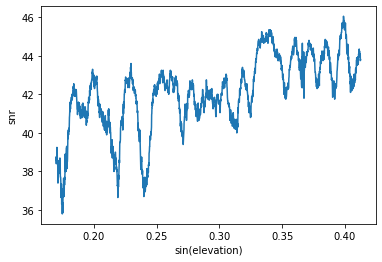

In [58]:
plt.plot(np.sin(elevation_filtered/180*math.pi),snr1_volt_filtered)
plt.xlabel('sin(elevation)')
plt.ylabel('snr')

In [59]:
para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),design_matrix.T),snr1_volt_filtered)
print(para)

[[-2.85059411e-03]
 [ 4.05739110e-01]
 [ 3.60823855e+01]]


(2046, 1)


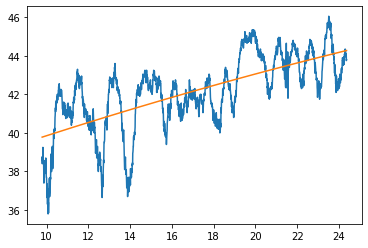

In [60]:
print(snr1_volt_filtered.shape)
snr1_ref = snr1_volt_filtered - (elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0])
plt.plot(elevation_filtered,snr1_volt_filtered)
plt.plot(elevation_filtered,(elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0]))


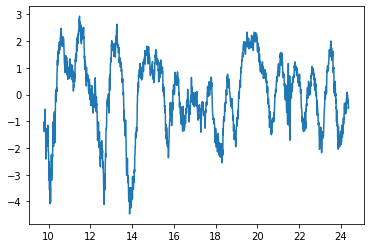

In [61]:
plt.plot(elevation_filtered,snr1_ref)

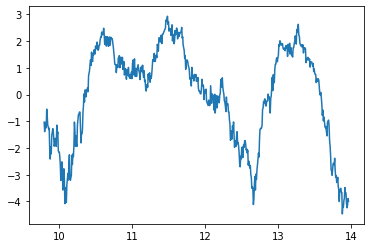

In [62]:
elevation_filtered_choosen = elevation_filtered[0:600]
snr1_ref_choosen = snr1_ref[0:600]
plt.plot(elevation_filtered_choosen,snr1_ref_choosen)


[4.35841584]


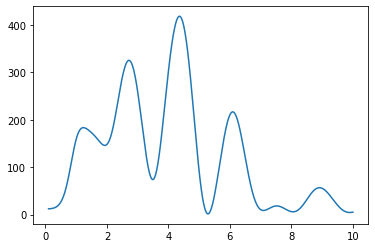

In [63]:
x_data = (np.sin(elevation_filtered_choosen*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
y_data = snr1_ref_choosen.ravel()
w = np.linspace(0.1,10,10000)
power = signal.lombscargle(x_data,y_data,w,normalize=True)
power = signal.lombscargle(x_data,y_data,w)
plt.plot(w,power)

peaks,_= signal.find_peaks(power)
peaks_power = power[peaks]

h = w[peaks]
h = h[peaks_power==max(peaks_power)]
print(h)

In [64]:
min_height = 1
max_height = 3 # meter
time_interval = 120 # minutes

time_delta = timedelta(minutes=time_interval)
time_start = dataframe['time'].iat[0]
time_end = time_start + time_delta
height_list = []
time_list = []
azimut_list = []
dataframe_in_interval = dataframe[(dataframe['time'] >= time_start) & \
                                    (dataframe['time'] < time_end)]



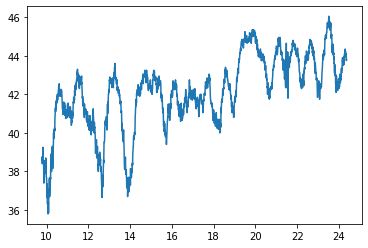

In [65]:
plt.plot(dataframe_in_interval['elevation'],dataframe_in_interval['snr1'])

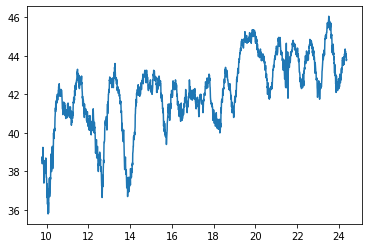

In [66]:
dataframe_in_interval_sort = dataframe_in_interval.sort_values(by='elevation')
# sort data by elevation
elevation_sort = np.array([dataframe_in_interval_sort['elevation']])
snr = np.array([dataframe_in_interval_sort['snr1']])
non_nan_index = ~np.isnan(snr)

# nanfilter
elevation_filtered = elevation_sort[non_nan_index]
elevation_filtered = elevation_filtered.reshape(elevation_filtered.size,1)
snr_filtered = snr[non_nan_index]
snr_filtered = snr_filtered.reshape(snr_filtered.size,1)
plt.plot(elevation_filtered,snr_filtered)

[2.726]


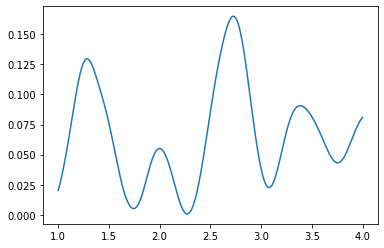

In [67]:
# calculate the snr_ref
design_matrix = np.concatenate((elevation_filtered**2,elevation_filtered,\
            np.ones((elevation_filtered.size,1))),axis=1)
try:
    para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                design_matrix.T),snr_filtered)
except:
    height = float("nan")
else:
    snr_ref = snr_filtered - (elevation_filtered**2 * para[0,0] + \
                para[1,0]*elevation_filtered + para[2,0])

    # lsp analysis
    x_data = (np.sin(elevation_filtered.T*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
    y_data = snr_ref.ravel()
    frequency = np.arange(min_height,max_height+1,0.001)

    power = signal.lombscargle(x_data,y_data,frequency,normalize=True)
    plt.plot(frequency,power)

    peaks,_= signal.find_peaks(power)
    if peaks.size != 0:
        peaks_power = power[peaks]

        height_peak = frequency[peaks]
        height_peak = height_peak[peaks_power==max(peaks_power)]
        height = height_peak
    else:
        height = float("nan")

print(height)